In [53]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

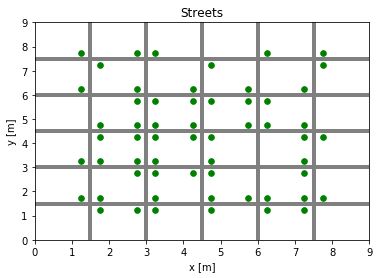

In [56]:
full_plot_line = np.arange(0, 10)

road0_y = np.array([3] * len(full_plot_line))
road0_x = np.array([3]  * len(full_plot_line))
road1_y = np.array([6] * len(full_plot_line))
road1_x = np.array([6]  * len(full_plot_line))

fig, ax = plt.subplots()

plt.axis([0, 9, 0, 9])

def cross_road_generator(count, grid_size = 9):
    place = grid_size / (count + 1)
    cross_points = []
    
    for r in range(count):
        ax.plot(full_plot_line, np.array([place + place * r] * len(full_plot_line)), color='gray', linewidth=4)
        ax.plot(np.array([place + place * r] * len(full_plot_line)), full_plot_line, color='gray', linewidth=4)
        cross_points.append(place + place * r)

    return [[p1, p2] for p1 in cross_points for p2 in cross_points]

def gen_ru(pairs):
    ru = []
    for p in pairs:
        if (random.random() > 0.5):
            ax.scatter(p[0] - 0.25, p[1] - 0.25, s=np.pi*10, c = "green")
            ru.append([p[0] - 0.25, p[1] - 0.25])
        if (random.random() > 0.5):
            ax.scatter(p[0] + 0.25, p[1] + 0.25, s=np.pi*10, c = "green")
            ru.append([p[0] + 0.25, p[1] + 0.25])
        if (random.random() > 0.5):
            ax.scatter(p[0] - 0.25, p[1] + 0.25, s=np.pi*10, c = "green")
            ru.append([p[0] - 0.25, p[1] + 0.25])
        if (random.random() > 0.5):
            ax.scatter(p[0] + 0.25, p[1] - 0.25, s=np.pi*10, c = "green")
            ru.append([p[0] + 0.25, p[1] - 0.25])
       
    
    return ru


pairs = cross_road_generator(5)
gen_ru(pairs)


ax.set(xlabel='x [m]', ylabel='y [m]',
       title='Streets')


fig.savefig("streets.png")
plt.show()

# 2. DU Relocation

Let $x_{jt}$ is binary variable (0 or 1) that represent state of DU connection for *j*th JP at  *t*th perion

$X(t) =  \{x_{1t}, x_{2t}, \dots \}$ - denotes state of DU connection for JPs at state t

The relocation DUs is described as a transition between the states using $X(t)$ 